In [7]:
import boto3
import numpy as np
import os
import sagemaker
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
from tqdm import tqdm
import awswrangler as wr

In [8]:
sess = sagemaker.Session()
sagemaker_iam_role = sagemaker.get_execution_role()

In [9]:
region = sagemaker.Session().boto_region_name
boto_session = boto3.Session(region_name=region)
sagemaker_boto_client = boto_session.client("sagemaker")

## Get Data from the feature store previously stored 

In [10]:
bucket_name="sagemaker-us-east-1-470086202700"
prefix='fraud_train'

athena_client = boto3.client('athena')

query_string = f"""
SELECT * FROM fraud_feature_group_1704739102
"""

output_location = f's3://{bucket_name}/{prefix}'

# Execute the query
response = athena_client.start_query_execution(
    QueryString=query_string,
    QueryExecutionContext={
        'Database': 'sagemaker_featurestore' 
    },
    ResultConfiguration={
        'OutputLocation': output_location,
    }
)

query_execution_id = response['QueryExecutionId']

In [11]:
def get_query_results(query_execution_id):
    # Check if the query has finished
    query_status = athena_client.get_query_execution(QueryExecutionId=query_execution_id)
    query_execution_status = query_status['QueryExecution']['Status']['State']
    #print(query_status['QueryExecution']['Status'])

    if query_execution_status == 'SUCCEEDED':
        print("Query succeeded, results are in:", output_location)
        return 200
    elif query_execution_status in ['FAILED', 'CANCELLED']:
        print(f"Query {query_execution_status.lower()}.")
        return 201
    else:
        print("Query in progress...")
        return -1

In [12]:
from time import sleep
while get_query_results(query_execution_id)<0:
    sleep(5)
    continue

Query in progress...
Query in progress...
Query succeeded, results are in: s3://sagemaker-us-east-1-470086202700/fraud_train


In [13]:
s3 = boto3.client('s3')

bucket_name = "sagemaker-us-east-1-470086202700"
prefix="fraud_train"
csv_key = f'{prefix}/{query_execution_id}.csv'  
metadata_key = f'{prefix}/{query_execution_id}.csv.metadata'  


local_csv_path = 'query_results.csv'
local_metadata_path = 'query_metadata.txt'

# Download the files
s3.download_file(bucket_name, csv_key, local_csv_path)
s3.download_file(bucket_name, metadata_key, local_metadata_path)

In [14]:
import pandas as pd
data = pd.read_csv(local_csv_path)
len(data)

284807

In [15]:
data.head()

,index,time,v1,v2,v3,v4,v5,v6,v7,v8,...,v25,v26,v27,v28,amount,class,event_time,write_time,api_invocation_time,is_deleted
0,231919,146980.0,1.578554,-0.873194,-0.448268,1.502326,-0.922585,-0.454326,-0.352790,0.010807,...,-0.234998,-0.572974,0.012331,-0.000839,197.50,0,2024-01-08T18:14:05Z,2024-01-08 19:24:27.248,2024-01-08 19:19:26.000,False
1,232017,147013.0,1.716147,-0.915384,-0.759103,0.314505,-0.602889,-0.243612,-0.342000,0.000520,...,-0.689479,0.194634,-0.080684,-0.012176,169.98,0,2024-01-08T18:14:05Z,2024-01-08 19:24:27.248,2024-01-08 19:19:27.000,False
2,232032,147017.0,1.876955,-0.542904,-0.788443,0.935131,-0.484605,-0.548919,-0.091843,-0.102952,...,-0.200279,0.098391,-0.043068,-0.049741,64.07,0,2024-01-08T18:14:05Z,2024-01-08 19:24:27.248,2024-01-08 19:19:27.000,False
3,232036,147018.0,2.052141,-0.152083,-1.093007,0.421538,-0.226477,-1.159381,0.083787,-0.236712,...,-0.356691,0.205318,-0.075936,-0.063205,1.98,0,2024-01-08T18:14:05Z,2024-01-08 19:24:27.248,2024-01-08 19:19:27.000,False
4,232341,147134.0,1.879608,-0.147519,-0.290181,1.566929,-0.287459,-0.052734,-0.232235,0.022360,...,-0.347230,-1.162158,0.054476,-0.015899,23.96,0,2024-01-08T18:14:05Z,2024-01-08 19:24:27.248,2024-01-08 19:19:30.000,False


In [16]:
data = data.drop(['event_time', 'write_time', 'api_invocation_time', 'is_deleted','index'], axis=1)

In [17]:
data.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,146980.0,1.578554,-0.873194,-0.448268,1.502326,-0.922585,-0.454326,-0.352790,0.010807,1.153715,...,0.325830,0.582835,-0.002262,-0.068033,-0.234998,-0.572974,0.012331,-0.000839,197.50,0
1,147013.0,1.716147,-0.915384,-0.759103,0.314505,-0.602889,-0.243612,-0.342000,0.000520,1.136865,...,-0.193805,-0.901484,0.320566,0.548267,-0.689479,0.194634,-0.080684,-0.012176,169.98,0
2,147017.0,1.876955,-0.542904,-0.788443,0.935131,-0.484605,-0.548919,-0.091843,-0.102952,1.350457,...,-0.342282,-0.749943,0.241729,-0.011103,-0.200279,0.098391,-0.043068,-0.049741,64.07,0
3,147018.0,2.052141,-0.152083,-1.093007,0.421538,-0.226477,-1.159381,0.083787,-0.236712,0.733189,...,-0.297944,-0.780066,0.362093,-0.048148,-0.356691,0.205318,-0.075936,-0.063205,1.98,0
4,147134.0,1.879608,-0.147519,-0.290181,1.566929,-0.287459,-0.052734,-0.232235,0.022360,1.042977,...,-0.483962,-1.133391,0.502859,1.018852,-0.347230,-1.162158,0.054476,-0.015899,23.96,0


In [18]:
## Moving class to first column
model_data = data
model_data.head()
model_data = pd.concat([model_data['class'], model_data.drop(['class'], axis=1)], axis=1)
model_data.head()

,class,time,v1,v2,v3,v4,v5,v6,v7,v8,...,v20,v21,v22,v23,v24,v25,v26,v27,v28,amount
0,0,146980.0,1.578554,-0.873194,-0.448268,1.502326,-0.922585,-0.454326,-0.352790,0.010807,...,0.017903,0.325830,0.582835,-0.002262,-0.068033,-0.234998,-0.572974,0.012331,-0.000839,197.50
1,0,147013.0,1.716147,-0.915384,-0.759103,0.314505,-0.602889,-0.243612,-0.342000,0.000520,...,0.120598,-0.193805,-0.901484,0.320566,0.548267,-0.689479,0.194634,-0.080684,-0.012176,169.98
2,0,147017.0,1.876955,-0.542904,-0.788443,0.935131,-0.484605,-0.548919,-0.091843,-0.102952,...,-0.198758,-0.342282,-0.749943,0.241729,-0.011103,-0.200279,0.098391,-0.043068,-0.049741,64.07
3,0,147018.0,2.052141,-0.152083,-1.093007,0.421538,-0.226477,-1.159381,0.083787,-0.236712,...,-0.312060,-0.297944,-0.780066,0.362093,-0.048148,-0.356691,0.205318,-0.075936,-0.063205,1.98
4,0,147134.0,1.879608,-0.147519,-0.290181,1.566929,-0.287459,-0.052734,-0.232235,0.022360,...,-0.208440,-0.483962,-1.133391,0.502859,1.018852,-0.347230,-1.162158,0.054476,-0.015899,23.96


In [19]:
#time=np.array(model_data['time']).mean()
#time

94813.85957508067

## Divide data into training, validation and test

In [20]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1229), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [13]:
prefix = 'xgboost-fraud'

train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)


boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')) \
                                .upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'validation/validation.csv')) \
                                .upload_file('validation.csv')

In [14]:
s3_train_data = 's3://{}/{}/train/train.csv'.format(bucket_name, prefix)
s3_validation_data = 's3://{}/{}/validation/validation.csv'.format(bucket_name, prefix)

print('Uploaded training data location: {}'.format(s3_train_data))
print('Uploaded training data location: {}'.format(s3_validation_data))

output_location = 's3://{}/{}/output'.format(bucket_name, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Uploaded training data location: s3://sagemaker-us-east-1-470086202700/xgboost-fraud/train/train.csv
Uploaded training data location: s3://sagemaker-us-east-1-470086202700/xgboost-fraud/validation/validation.csv
Training artifacts will be uploaded to: s3://sagemaker-us-east-1-470086202700/xgboost-fraud/output


## Train XGBOOST. Can also Used unsupervised learning algorithms like RANDOM CUT but will keep it simple here

In [15]:
container = sagemaker.image_uris.retrieve("xgboost", sess.boto_region_name, "1.7-1")
container

'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1'

In [16]:
s3_input_train = TrainingInput(s3_data="s3://{}/{}/train".format(bucket_name, prefix), content_type="csv")
s3_input_validation = TrainingInput(s3_data="s3://{}/{}/validation/".format(bucket_name, prefix), content_type="csv")

In [17]:
xgb = sagemaker.estimator.Estimator(container,
                                    role=sagemaker_iam_role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=sess)

In [18]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        verbosity=0,
                        objective='binary:logistic',
                        num_round=100)

In [132]:
s3_input_train

## Train the model

In [19]:
xgb.fit({"train": s3_input_train, "validation": s3_input_validation})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-01-08-22-21-12-629


2024-01-08 22:21:12 Starting - Starting the training job...
2024-01-08 22:21:30 Starting - Preparing the instances for training.........
2024-01-08 22:22:56 Downloading - Downloading input data......
2024-01-08 22:23:45 Downloading - Downloading the training image...
2024-01-08 22:24:41 Training - Training image download completed. Training in progress...[2024-01-08 22:24:52.850 ip-10-0-234-84.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-01-08 22:24:52.881 ip-10-0-234-84.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-01-08:22:24:53:INFO] Imported framework sagemaker_xgboost_container.training
[2024-01-08:22:24:53:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2024-01-08:22:24:53:INFO] No GPUs detected (normal if no gpus installed)
[2024-01-08:22:24:53:INFO] Running XGBoost Sagemaker in algorithm mode
[2024-01-08:22:24:53:INFO] Determined 0 GPU(s) available on t


2024-01-08 22:25:41 Uploading - Uploading generated training model[70]#011train-logloss:0.00142#011validation-logloss:0.00245
[71]#011train-logloss:0.00140#011validation-logloss:0.00245
[72]#011train-logloss:0.00138#011validation-logloss:0.00248
[73]#011train-logloss:0.00137#011validation-logloss:0.00248
[74]#011train-logloss:0.00136#011validation-logloss:0.00249
[75]#011train-logloss:0.00135#011validation-logloss:0.00249
[76]#011train-logloss:0.00134#011validation-logloss:0.00249
[77]#011train-logloss:0.00132#011validation-logloss:0.00248
[78]#011train-logloss:0.00131#011validation-logloss:0.00250
[79]#011train-logloss:0.00130#011validation-logloss:0.00250
[80]#011train-logloss:0.00129#011validation-logloss:0.00251
[81]#011train-logloss:0.00128#011validation-logloss:0.00251
[82]#011train-logloss:0.00126#011validation-logloss:0.00251
[83]#011train-logloss:0.00125#011validation-logloss:0.00252
[84]#011train-logloss:0.00125#011validation-logloss:0.00251
[85]#011train-logloss:0.00124#011

## Deploy model

In [33]:
xgb.name = 'deployed-xgboost-fraud-prediction'
xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge',endpoint_name='deployed-xgboost-fraud-prediction')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-01-08-22-51-48-221
INFO:sagemaker:Creating endpoint-config with name deployed-xgboost-fraud-prediction


ClientError: An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:us-east-1:470086202700:endpoint-config/deployed-xgboost-fraud-prediction".

## Create XG boost Realtime predictor usign deployed endpoint if we donot have previous estimator object which is the case in actual deployment. Can also use async inference if the payload is too big not the case here

In [35]:
import sagemaker
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import StringDeserializer

endpoint_name = 'deployed-xgboost-fraud-prediction' 

# Create a real-time predictor
xgb_predictor = sagemaker.predictor.Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sess,
    serializer=CSVSerializer(),       
    deserializer=StringDeserializer()   
)


## Evaluate model

In [53]:
len(train_data),len(validation_data),len(test_data)

(199364, 56962, 28481)

In [69]:
import json

def predict(data, rows=500):
    # Convert the DataFrame to a NumPy array
    data_array = data.to_numpy() if hasattr(data, 'to_numpy') else data.values    
    # Split the array into smaller arrays of size 'rows'
    split_array = np.array_split(data_array, int(data_array.shape[0] / float(rows) + 1))   
    predictions = []
    for array in split_array:
        # Assuming xgb_predictor is your model's predictor and it can handle NumPy arrays directly
        prediction_result = xgb_predictor.predict(array)
        parsed_result = json.loads(prediction_result)     
        scores = [item['score'] for item in parsed_result['predictions']]
        predictions.extend(scores)
    return predictions


In [70]:
predictions = predict(test_data.iloc[:, 1:])
labels =test_data.iloc[:,0]

In [72]:
len(predictions), len(labels)

(28481, 28481)

In [62]:
test_nonfrauds, test_frauds = test_data.groupby('class').size()
print('Number of frauds: ', test_frauds)
print('Number of non-frauds: ', test_nonfrauds)
print('Percentage of fradulent data:', 100.*test_frauds/(test_frauds + test_nonfrauds))

Number of frauds:  45
Number of non-frauds:  28436
Percentage of fradulent data: 0.15800007022225343


In [74]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

rounded_predictions = np.round(predictions)

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(labels, rounded_predictions)

# Calculate F1 Score
f1score = f1_score(labels, rounded_predictions)

# Precision Recall
f_Suport = precision_recall_fscore_support(labels,rounded_predictions)

print('precision: ', round(f_Suport [0][1], 2))
print('recall: ', round(f_Suport [1][1], 2))
print('F1 Score: ', round(f1score, 2))

precision:  0.9
recall:  0.82
F1 Score:  0.86


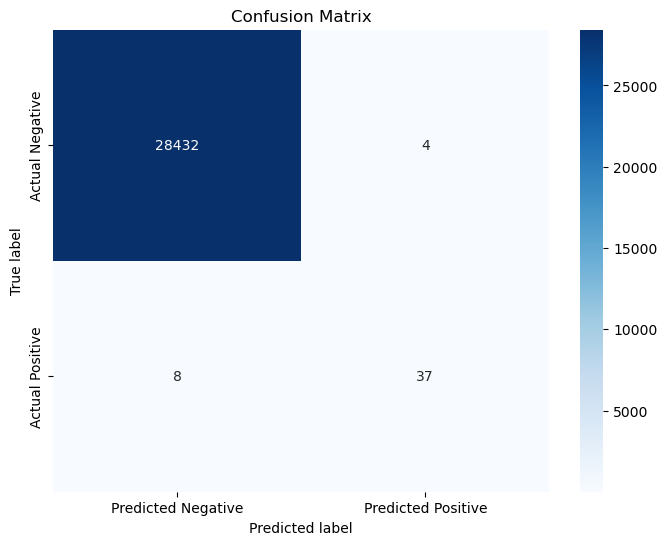

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

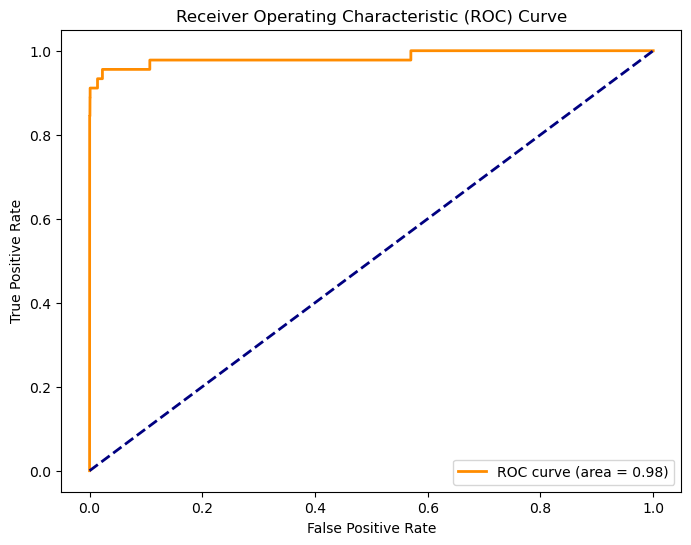

In [77]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(labels, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [78]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
precision, recall, _ = precision_recall_curve(labels, predictions)
auc_score = auc(recall, precision)

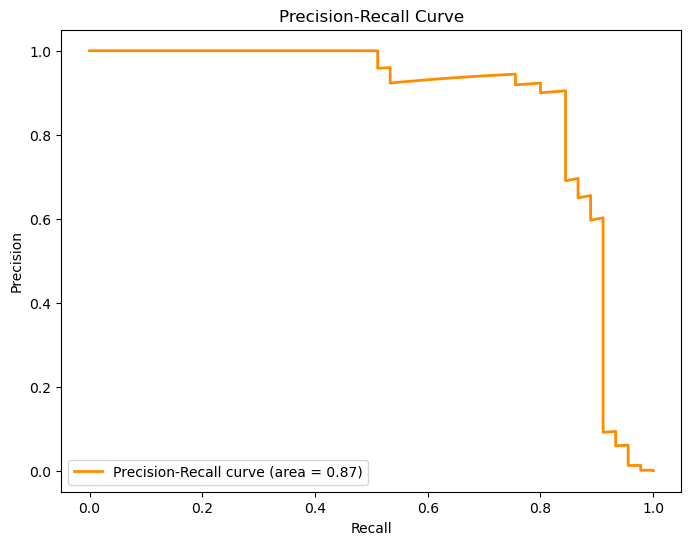

In [79]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (area = {auc_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


## More than precision and recall assigigng cost using real world heuristics

In [81]:
def calculate_cost(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = 500 * fn + 0 * tn + 100 * fp + 100 * tp
    return cost

In [84]:
thresholds = np.linspace(0, 1, 1000)  # Create a range of possible thresholds
optimal_threshold = None
min_cost = float('inf')

for threshold in tqdm(thresholds):
    predicted_labels = (predictions >= threshold).astype(int)
    
    # Calculate cost for this threshold
    cost = calculate_cost(labels, predicted_labels)
    
    if cost < min_cost:
        min_cost = cost
        optimal_threshold = threshold

# Print the optimal threshold
print(f"Optimal Threshold: {optimal_threshold}, Minimum Cost: {min_cost}")

100%|██████████| 1000/1000 [00:05<00:00, 188.74it/s]

Optimal Threshold: 0.4214214214214214, Minimum Cost: 7700


## Track Lineage of data and model

## Registering artifacts

In [88]:
training_job_name = xgb.latest_training_job.job_name

In [89]:
training_job_name

'sagemaker-xgboost-2024-01-08-22-21-12-629'

In [92]:
training_job_xgboost_info = sess.describe_training_job(training_job_name)

In [101]:
training_job_xgboost_info 

{'TrainingJobName': 'sagemaker-xgboost-2024-01-08-22-21-12-629',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:470086202700:training-job/sagemaker-xgboost-2024-01-08-22-21-12-629',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-470086202700/xgboost-fraud/output/sagemaker-xgboost-2024-01-08-22-21-12-629/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'eta': '0.2',
  'gamma': '4',
  'max_depth': '5',
  'min_child_weight': '6',
  'num_round': '100',
  'objective': 'binary:logistic',
  'subsample': '0.8',
  'verbosity': '0'},
 'AlgorithmSpecification': {'TrainingImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1',
  'TrainingInputMode': 'File',
  'MetricDefinitions': [{'Name': 'train:mae',
    'Regex': '.*\\[[0-9]+\\].*#011train-mae:([-+]?[0-9]*\\.?[0-9]+(?:[eE][-+]?[0-9]+)?).*'},
   {'Name': 'validation:aucpr',
    'Regex': '.*\\[[0-9]+\\].*#011validation-aucpr:([-+]?[0-9]*\\.?[

## Registering Code Artifacts

In [102]:
# extract the training code uri and check if it's an exisiting artifact
code_s3_uri = training_job_xgboost_info["AlgorithmSpecification"]['TrainingImage']

In [103]:
code_s3_uri

'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1'

In [104]:
matching_artifacts = list(sagemaker.lineage.artifact.Artifact.list(source_uri=code_s3_uri, sagemaker_session=sess))

In [106]:
# use existing arifact if it's already been created, otherwise create a new artifact
if matching_artifacts:
    code_artifact = matching_artifacts[0]
    print(f"Using existing artifact: {code_artifact.artifact_arn}")
else:
    code_artifact = sagemaker.lineage.artifact.Artifact.create(
        artifact_name="TrainingImage",
        source_uri=code_s3_uri,
        artifact_type="Code",
        sagemaker_session=sess,
    )
    print(f"Create artifact {code_artifact.artifact_arn}: SUCCESSFUL")

Using existing artifact: arn:aws:sagemaker:us-east-1:470086202700:artifact/9d7522c83447ffcca9ada42e3dbcd2cb


## Registering Training data artifact

In [109]:
training_data_s3_uri = training_job_xgboost_info["InputDataConfig"][0]["DataSource"]["S3DataSource"]["S3Uri"]

In [110]:
training_data_s3_uri

's3://sagemaker-us-east-1-470086202700/xgboost-fraud/train'

In [111]:
matching_artifacts = list(sagemaker.lineage.artifact.Artifact.list(source_uri=training_data_s3_uri, sagemaker_session=sess))

if matching_artifacts:
    training_data_artifact = matching_artifacts[0]
    print(f"Using existing artifact: {training_data_artifact.artifact_arn}")
else:
    training_data_artifact = sagemaker.lineage.artifact.Artifact.create(
        artifact_name="TrainingData",
        source_uri=training_data_s3_uri,
        artifact_type="Dataset",
        sagemaker_session=sess,
    )
    print(f"Create artifact {training_data_artifact.artifact_arn}: SUCCESSFUL")

Using existing artifact: arn:aws:sagemaker:us-east-1:470086202700:artifact/9c29ddda99823962f0345a01f710422b


## Registering validation data artifact

In [112]:
validation_data_s3_uri = training_job_xgboost_info["InputDataConfig"][1]["DataSource"]["S3DataSource"]["S3Uri"]

In [114]:
validation_data_s3_uri

's3://sagemaker-us-east-1-470086202700/xgboost-fraud/validation/'

In [115]:
matching_artifacts = list(sagemaker.lineage.artifact.Artifact.list(source_uri=validation_data_s3_uri, sagemaker_session=sess))

if matching_artifacts:
    validation_data_artifact = matching_artifacts[0]
    print(f"Using existing artifact: {validation_data_artifact.artifact_arn}")
else:
    training_data_artifact = sagemaker.lineage.artifact.Artifact.create(
        artifact_name="ValidationData",
        source_uri=validation_data_s3_uri,
        artifact_type="Dataset",
        sagemaker_session=sess,
    )
    print(f"Create artifact {training_data_artifact.artifact_arn}: SUCCESSFUL")

Using existing artifact: arn:aws:sagemaker:us-east-1:470086202700:artifact/3e45d98d033fa0793141ed1e9c9361d2


## Registering HP Artifacts

In [146]:
hp_params=json.dumps(training_job_xgboost_info['HyperParameters'])
# Upload the hyperparameters JSON to S3
hp_key=f"{prefix}/hp.json"
s3.put_object(Bucket=bucket_name, Key=hp_key, Body=hp_params)
# The source URI for the artifact
source_uri = f's3://{bucket_name}/{hp_key}'

In [147]:
source_uri

's3://sagemaker-us-east-1-470086202700/xgboost-fraud/hp.json'

In [148]:
# Check for existing artifacts
matching_artifacts = list(sagemaker.lineage.artifact.Artifact.list(source_uri=source_uri, sagemaker_session=sess))

if matching_artifacts:
    hp_artifact = matching_artifacts[0]
    print(f"Using existing artifact: {hp_artifact.artifact_arn}")
else:
    hp_artifact = sagemaker.lineage.artifact.Artifact.create(
        artifact_name="HP",
        source_uri=source_uri,
        artifact_type="HyperParameters",
        sagemaker_session=sess,
    )
    print(f"Created new artifact {hp_artifact.artifact_arn}: SUCCESSFUL")

Created new artifact arn:aws:sagemaker:us-east-1:470086202700:artifact/c8b1ea6afc0c3bac4a7aed9b19131a12: SUCCESSFUL


## Registering model artifacts

In [117]:
trained_model_s3_uri = training_job_xgboost_info["ModelArtifacts"]["S3ModelArtifacts"]

In [118]:
trained_model_s3_uri

's3://sagemaker-us-east-1-470086202700/xgboost-fraud/output/sagemaker-xgboost-2024-01-08-22-21-12-629/output/model.tar.gz'

In [119]:
matching_artifacts = list(sagemaker.lineage.artifact.Artifact.list(source_uri=trained_model_s3_uri, sagemaker_session=sess))

if matching_artifacts:
    model_artifact = matching_artifacts[0]
    print(f"Using existing artifact: {model_artifact.artifact_arn}")
else:
    model_artifact = sagemaker.lineage.artifact.Artifact.create(
        artifact_name="TrainedModel",
        source_uri=trained_model_s3_uri,
        artifact_type="Model",
        sagemaker_session=sess,
    )
    print(f"Create artifact {model_artifact.artifact_arn}: SUCCESSFUL")

Using existing artifact: arn:aws:sagemaker:us-east-1:470086202700:artifact/5901727180a2fa63b4e0eb08775a24cc


## Assoiciate artifacts

In [152]:
trial_component = sagemaker_boto_client.describe_trial_component(TrialComponentName=training_job_name + "-aws-training-job")
trial_component_arn = trial_component["TrialComponentArn"]

In [153]:
trial_component_arn

'arn:aws:sagemaker:us-east-1:470086202700:experiment-trial-component/sagemaker-xgboost-2024-01-08-22-21-12-629-aws-training-job'

In [154]:
input_artifacts = [code_artifact, training_data_artifact,validation_data_artifact,hp_artifact]

for a in input_artifacts:
    try:
        sagemaker.lineage.association.Association.create(
            source_arn=a.artifact_arn,
            destination_arn=trial_component_arn,
            association_type="ContributedTo",
            sagemaker_session=sess,
        )
        print(f"Association with {a.artifact_type}: SUCCEESFUL")
    except:
        print(f"Association already exists with {a.artifact_type}")

Association already exists with Image
Association already exists with DataSet
Association already exists with DataSet
Association already exists with HyperParameters


In [144]:
output_artifacts = [model_artifact]
for a in output_artifacts:
    try:
        sagemaker.lineage.association.Association.create(
            source_arn=a.artifact_arn,
            destination_arn=trial_component_arn,
            association_type="Produced",
            sagemaker_session=sess,
        )
        print(f"Association with {a.artifact_type}: SUCCESSFUL")
    except:
        print(f"Association already exists with {a.artifact_type}")

Association with Model: SUCCESSFUL


## Fairness and bias using Amazon clarify 

In [159]:
train_data="s3://{}/{}/train".format(bucket_name, prefix)

In [160]:
train_data

's3://sagemaker-us-east-1-470086202700/xgboost-fraud/train'

In [212]:
#train_cols = wr.s3.read_csv(training_data_s3_uri).columns.to_list()
train_cols = model_data.columns.to_list()


In [213]:
clarify_processor = sagemaker.clarify.SageMakerClarifyProcessor(
    role=sagemaker_iam_role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    sagemaker_session=sess,
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [214]:
bias_report_1_output_path = f"s3://{bucket_name}/{prefix}/clarify-output/bias_1"

In [215]:
bias_report_1_output_path

's3://sagemaker-us-east-1-470086202700/xgboost-fraud/clarify-output/bias_1'

In [216]:
bias_data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=s3_train_data,
    s3_output_path=bias_report_1_output_path,
    label="class",
    headers=train_cols,
    dataset_type="text/csv",
)

In [217]:
model_1_name = f"sagemaker-xgboost"
model_matches = sagemaker_boto_client.list_models(NameContains=model_1_name)["Models"]

if not model_matches:
    model_1 = sagemaker_session.create_model_from_job(
        name=model_1_name,
        training_job_name=training_job_1_info["TrainingJobName"],
        role=sagemaker_role,
        image_uri=training_job_1_info["AlgorithmSpecification"]["TrainingImage"],
    )
else:
    model_1_name=model_matches[0]['ModelName']
    print(f"Model {model_1_name} already exists.")

Model sagemaker-xgboost-2024-01-08-22-51-48-221 already exists.


In [218]:
train_instance_type = "ml.m4.xlarge"
model_1_name

'sagemaker-xgboost-2024-01-08-22-51-48-221'

In [219]:
model_config = sagemaker.clarify.ModelConfig(
    model_name=model_1_name,
    instance_type=train_instance_type,
    instance_count=1,
    accept_type="text/csv",
)

In [220]:
predictions_config = sagemaker.clarify.ModelPredictedLabelConfig(probability_threshold=0.5)

In [221]:
from sagemaker.clarify import BiasConfig

time_threshold = int(time) 

bias_config = BiasConfig(
    label_values_or_threshold=[0],  # Assuming 0 is the value of interest for your label
    facet_name="time",          # Replace with your time feature column name
    facet_values_or_threshold=[time_threshold],
)

In [222]:
if 'clarify_bias_job_1_name' not in locals():
    
    clarify_processor.run_bias(
     data_config=bias_data_config,
     bias_config=bias_config,
     model_config=model_config,
     model_predicted_label_config=predictions_config,
     pre_training_methods='all',
     post_training_methods='all')
    
    clarify_bias_job_1_name = clarify_processor.latest_job.name
    
else:
    print(f'Clarify job {clarify_bias_job_name} has already run successfully.')

INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['class', 'time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount'], 'label': 'class', 'label_values_or_threshold': [0], 'facet': [{'name_or_index': 'time', 'value_or_threshold': [94813]}], 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'pre_training_bias': {'methods': 'all'}, 'post_training_bias': {'methods': 'all'}}, 'predictor': {'model_name': 'sagemaker-xgboost-2024-01-08-22-51-48-221', 'instance_type': 'ml.m4.xlarge', 'initial_instance_count': 1, 'accept_type': 'text/csv'}, 'probability_threshold': 0.5}
INFO:sagemaker:Creating processing-job with name Clarify-Bias-2024-01-09-17-06-59-811


...........................................2024-01-09 17:14:11,962 logging.conf not found when configuring logging, using default logging configuration.
2024-01-09 17:14:11,963 Starting SageMaker Clarify Processing job
2024-01-09 17:14:11,964 Analysis config path: /opt/ml/processing/input/config/analysis_config.json
2024-01-09 17:14:11,964 Analysis result path: /opt/ml/processing/output
2024-01-09 17:14:11,965 This host is algo-1.
2024-01-09 17:14:11,965 This host is the leader.
2024-01-09 17:14:11,965 Number of hosts in the cluster is 1.
2024-01-09 17:14:12,223 Running Python / Pandas based analyzer.
2024-01-09 17:14:12,223 Dataset type: text/csv uri: /opt/ml/processing/input/data
2024-01-09 17:14:12,235 Loading dataset...
/usr/local/lib/python3.9/site-packages/analyzer/data_loading/csv_data_loader.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_tmp, ignore_index=True)
2024

2024-01-09 17:19:36,418 ======================================
2024-01-09 17:19:36,418 Calculating bias statistics for report
2024-01-09 17:19:36,418 ======================================
2024-01-09 17:19:36,420 Column class with data uniqueness fraction 1.0031901446600189e-05 is classifed as a CATEGORICAL column
2024-01-09 17:19:36,429 Column time with data uniqueness fraction 0.5373487690856925 is classifed as a CONTINUOUS column
/usr/local/lib/python3.9/site-packages/smclarify/bias/report.py:591: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(facet_column.name, 1)
2024-01-09 17:19:36,446 Column class with data uniqueness fraction 1.0031901446600189e-05 is classifed as a CATEGORICAL column
2024-01-09 17:19:36,451 Column None with data uniqueness fraction 1.0031901446600189e-05 is classifed as a CATEGORICAL column
2024-01-09 17:19:36,454 Threshold Interval indices: IntervalIndex([(9481

In [234]:
!aws s3 cp s3://{bucket_name}/{prefix}/clarify-output/bias_1/report.pdf ./

download: s3://sagemaker-us-east-1-470086202700/xgboost-fraud/clarify-output/bias_1/report.pdf to ./report.pdf


## Group and Register model

In [237]:
mpg_name = "fraud-detection"
print(f"Model Package Group name: {mpg_name}")

Model Package Group name: fraud-detection


In [238]:
mpg_input_dict = {
    "ModelPackageGroupName": mpg_name,
    "ModelPackageGroupDescription": "Credit fraud Detection",
}

In [239]:
matching_mpg = sagemaker_boto_client.list_model_package_groups(NameContains=mpg_name)['ModelPackageGroupSummaryList']

if matching_mpg:
    print(f'Using existing Model Package Group: {mpg_name}')
else:
    mpg_response = sagemaker_boto_client.create_model_package_group(**mpg_input_dict)
    print(f'Create Model Package Group {mpg_name}: SUCCESSFUL')
    %store mpg_name

Create Model Package Group fraud-detection: SUCCESSFUL
Stored 'mpg_name' (str)


In [240]:
## updated metrics

In [242]:
model_metrics_report = {"binary_classification_metrics": {}}
for metric in training_job_xgboost_info["FinalMetricDataList"]:
    stat = {metric["MetricName"]: {"value": metric["Value"], "standard_deviation": "NaN"}}
    model_metrics_report["binary_classification_metrics"].update(stat)

In [244]:
model_metrics_report

{'binary_classification_metrics': {'validation:logloss': {'value': 0.0025400000158697367,
   'standard_deviation': 'NaN'},
  'train:logloss': {'value': 0.0011099999537691474,
   'standard_deviation': 'NaN'}}}

In [247]:
with open("training_metrics.json", "w") as f:
    json.dump(model_metrics_report, f)

In [245]:
metrics_s3_key = (f"{prefix}/training_jobs/{training_job_xgboost_info['TrainingJobName']}/training_metrics.json")

In [249]:
s3.upload_file(Filename="training_metrics.json", Bucket=bucket_name, Key=metrics_s3_key)

In [250]:
## Inference Specs

In [257]:
training_job_xgboost_info

{'TrainingJobName': 'sagemaker-xgboost-2024-01-08-22-21-12-629',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:470086202700:training-job/sagemaker-xgboost-2024-01-08-22-21-12-629',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-470086202700/xgboost-fraud/output/sagemaker-xgboost-2024-01-08-22-21-12-629/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'eta': '0.2',
  'gamma': '4',
  'max_depth': '5',
  'min_child_weight': '6',
  'num_round': '100',
  'objective': 'binary:logistic',
  'subsample': '0.8',
  'verbosity': '0'},
 'AlgorithmSpecification': {'TrainingImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1',
  'TrainingInputMode': 'File',
  'MetricDefinitions': [{'Name': 'train:mae',
    'Regex': '.*\\[[0-9]+\\].*#011train-mae:([-+]?[0-9]*\\.?[0-9]+(?:[eE][-+]?[0-9]+)?).*'},
   {'Name': 'validation:aucpr',
    'Regex': '.*\\[[0-9]+\\].*#011validation-aucpr:([-+]?[0-9]*\\.?[

In [262]:
model_url = training_job_xgboost_info['ModelArtifacts']['S3ModelArtifacts']
model_image= training_job_xgboost_info['AlgorithmSpecification']['TrainingImage']

mp_inference_spec =  {
    "InferenceSpecification": {
      "Containers": [
         {
            "Image": model_image,
             "ModelDataUrl": model_url
         }
      ],
      "SupportedContentTypes": [ "text/csv" ],
      "SupportedResponseMIMETypes": [ "text/csv" ],
   }
 }

In [259]:
## Define model metrics

In [260]:
model_metrics = {
    "ModelQuality": {
        "Statistics": {
            "ContentType": "application/json",
            "S3Uri": f"s3://{bucket_name}/{metrics_s3_key}",
        }
    },
    "Bias": {
        "Report": {
            "ContentType": "application/json",
            "S3Uri": f"{bias_report_1_output_path}/analysis.json",
        }
    },
}

In [261]:
mp_input_dict = {
    "ModelPackageGroupName": mpg_name,
    "ModelPackageDescription": "XGBoost classifier to detect credit fraud.",
    "ModelApprovalStatus": "PendingManualApproval",
    "ModelMetrics": model_metrics,
}

In [263]:
mp_input_dict.update(mp_inference_spec)

In [264]:
mp1_response = sagemaker_boto_client.create_model_package(**mp_input_dict)

In [265]:
## wait for model package to be craeted

In [266]:
mp_info = sagemaker_boto_client.describe_model_package(
    ModelPackageName=mp1_response["ModelPackageArn"]
)
mp_status = mp_info["ModelPackageStatus"]

while mp_status not in ["Completed", "Failed"]:
    time.sleep(5)
    mp_info = sagemaker_boto_client.describe_model_package(
        ModelPackageName=mp1_response["ModelPackageArn"]
    )
    mp_status = mp_info["ModelPackageStatus"]
    print(f"model package status: {mp_status}")
print(f"model package status: {mp_status}")

model package status: Completed


## View model package

In [268]:
sagemaker_boto_client.list_model_packages(ModelPackageGroupName=mpg_name)["ModelPackageSummaryList"]

[{'ModelPackageGroupName': 'fraud-detection',
  'ModelPackageVersion': 1,
  'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:470086202700:model-package/fraud-detection/1',
  'ModelPackageDescription': 'XGBoost classifier to detect credit fraud.',
  'CreationTime': datetime.datetime(2024, 1, 9, 19, 10, 41, 620000, tzinfo=tzlocal()),
  'ModelPackageStatus': 'Completed',
  'ModelApprovalStatus': 'PendingManualApproval'}]